In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Paths
DATA_DIR = Path("../data/processed")
OUTPUT_MERGED = DATA_DIR / "merged_all_assets.csv"
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
# Load dataset
df_all = pd.read_csv(OUTPUT_MERGED)
df_all["Date"] = pd.to_datetime(df_all["Date"])
df_all = df_all.sort_values("Date").reset_index(drop=True)

print(f"Dataset shape: {df_all.shape}")
df_all.head()

Dataset shape: (12351, 24)


,Date,Close,High,Low,Open,Volume,Ticker,Return,Volatility_5d,Volatility_21d,...,ATR_14,SMA_20,SMA_50,SMA_200,tweet_sentiment_mean,tweet_sentiment_std,tweet_count,news_sentiment_mean,news_sentiment_std,news_count
0,2015-10-13,10115.290039,10229.289929,10049.790102,10227.390517,259780200,IBEX35,-0.012795,0.159683,0.269366,...,219.585324,9811.945020,10157.991777,10819.799014,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-10-14,10037.589844,10128.990145,9992.390669,10065.390598,253688800,IBEX35,-0.007681,0.156205,0.270263,...,213.657763,9814.985010,10133.153809,10818.233018,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-10-15,10101.690430,10132.690400,10055.089889,10132.089814,239299900,IBEX35,0.006386,0.168101,0.262564,...,205.189391,9814.740039,10110.115859,10818.775020,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-10-16,10231.489258,10243.989245,10153.088950,10174.889708,246079200,IBEX35,0.012849,0.169364,0.262469,...,200.697207,9833.954980,10091.181875,10820.577017,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-10-16,2033.109985,2033.540039,2020.459961,2024.369995,3595430000,S&P500,0.004570,0.136368,0.176075,...,27.336910,1966.829993,1984.670801,2059.898853,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Define features and target
TARGET = "Volatility_5d"

feature_cols = [
    # Market features
    "Return", "Volatility_21d", "RSI_14", "MACD", "MACD_signal",
    "MACD_hist", "ATR_14", "SMA_20", "SMA_50", "SMA_200",
    # Sentiment features
    "tweet_sentiment_mean", "tweet_sentiment_std", "tweet_count",
    "news_sentiment_mean", "news_sentiment_std", "news_count"
]

# Drop rows with NaNs in features or target
df_all = df_all.dropna(subset=feature_cols + [TARGET])
print(f"Dataset after cleaning: {df_all.shape}")

Dataset after cleaning: (12351, 24)


In [5]:
# Train/Test split
split_idx = int(len(df_all) * 0.8)
train_df = df_all.iloc[:split_idx]
test_df  = df_all.iloc[split_idx:]

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 9880, Test size: 2471


In [6]:
# Scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
X_test_scaled  = scaler_X.transform(test_df[feature_cols])

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(train_df[[TARGET]]).ravel()
y_test_scaled  = scaler_y.transform(test_df[[TARGET]]).ravel()

joblib.dump(scaler_X, MODELS_DIR / "scaler_X_multimodal_dl.pkl")
joblib.dump(scaler_y, MODELS_DIR / "scaler_y_multimodal_dl.pkl")

['..\\models\\scaler_y_multimodal_dl.pkl']

In [7]:
# PyTorch Dataset Class
class VolatilityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = VolatilityDataset(X_train_scaled, y_train_scaled)
test_dataset  = VolatilityDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# Define MLP model
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

model = MLPRegressor(len(feature_cols)).to(DEVICE)

In [9]:
# Training parameters
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 100
best_loss = float("inf")

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).view(-1, 1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(test_loader.dataset)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), MODELS_DIR / "volatility_model_multimodal_mlp.pth")

    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch [1/100] - Train Loss: 0.4199 - Val Loss: 0.7202
Epoch [11/100] - Train Loss: 0.2735 - Val Loss: 2.1496
Epoch [21/100] - Train Loss: 0.2699 - Val Loss: 1.8193
Epoch [31/100] - Train Loss: 0.2516 - Val Loss: 1.1468
Epoch [41/100] - Train Loss: 0.2543 - Val Loss: 0.7238
Epoch [51/100] - Train Loss: 0.2507 - Val Loss: 0.6083
Epoch [61/100] - Train Loss: 0.2487 - Val Loss: 0.5837
Epoch [71/100] - Train Loss: 0.2456 - Val Loss: 0.4029
Epoch [81/100] - Train Loss: 0.2391 - Val Loss: 0.3950
Epoch [91/100] - Train Loss: 0.2373 - Val Loss: 0.4531
Epoch [100/100] - Train Loss: 0.2439 - Val Loss: 0.3857


In [10]:
# Load best model
model.load_state_dict(torch.load(MODELS_DIR / "volatility_model_multimodal_mlp.pth"))
model.eval()

# Predictions
y_pred_scaled = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        y_pred_scaled.extend(outputs.cpu().numpy())

y_pred_scaled = np.array(y_pred_scaled).ravel()

# Inverse scaling
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.0885
MAE: 0.0565
R²: 0.4771


In [11]:
# Save predictions
pred_df = pd.DataFrame({
    "Date": test_df["Date"].values,
    "Ticker": test_df["Ticker"].values,
    "Actual_Volatility": y_true,
    "Predicted_Volatility": y_pred
})

pred_df.to_csv(MODELS_DIR / "predictions_multimodal_mlp.csv", index=False)
pred_df.head()

,Date,Ticker,Actual_Volatility,Predicted_Volatility
0,2023-08-14,AAPL,0.110425,0.255277
1,2023-08-14,MSFT,0.148567,0.303917
2,2023-08-15,MSFT,0.132586,0.278173
3,2023-08-15,AAPL,0.130014,0.184607
4,2023-08-15,IBEX35,0.159442,0.148570


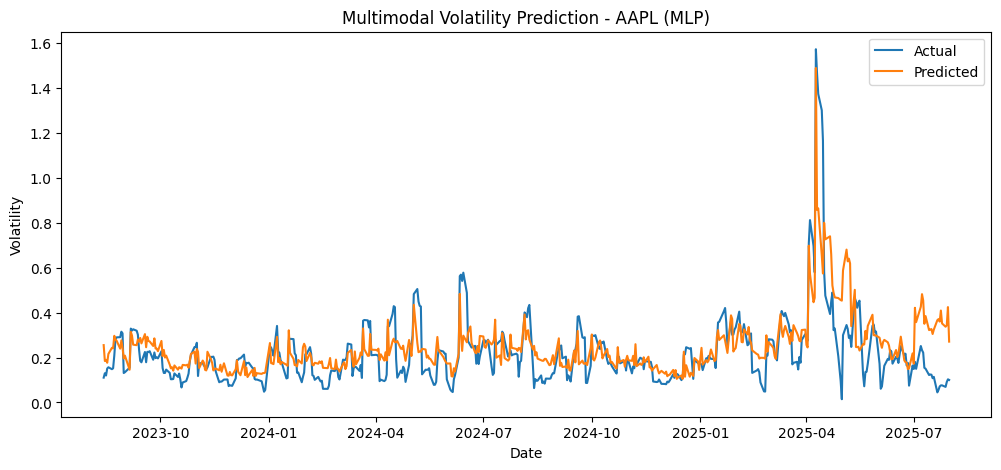

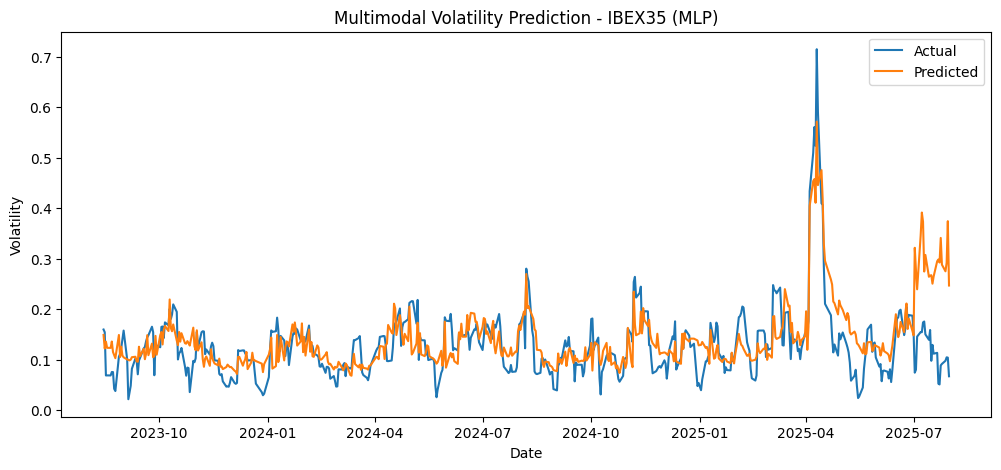

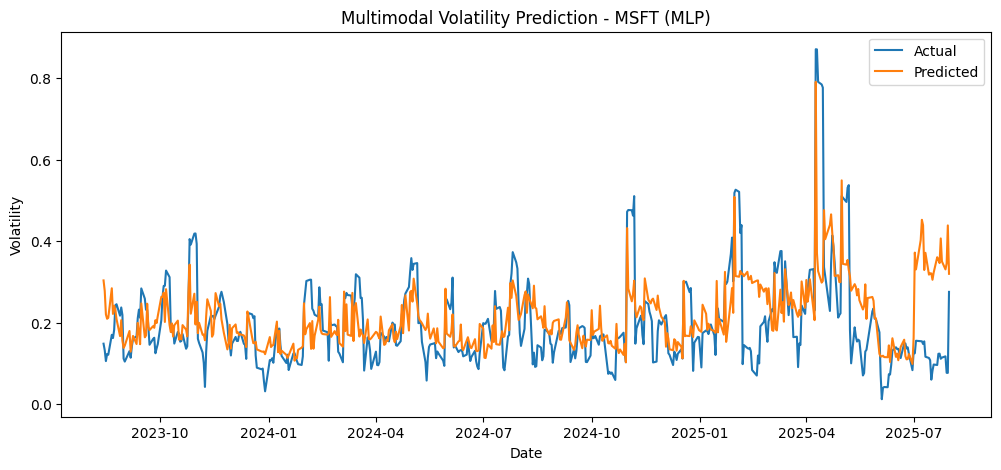

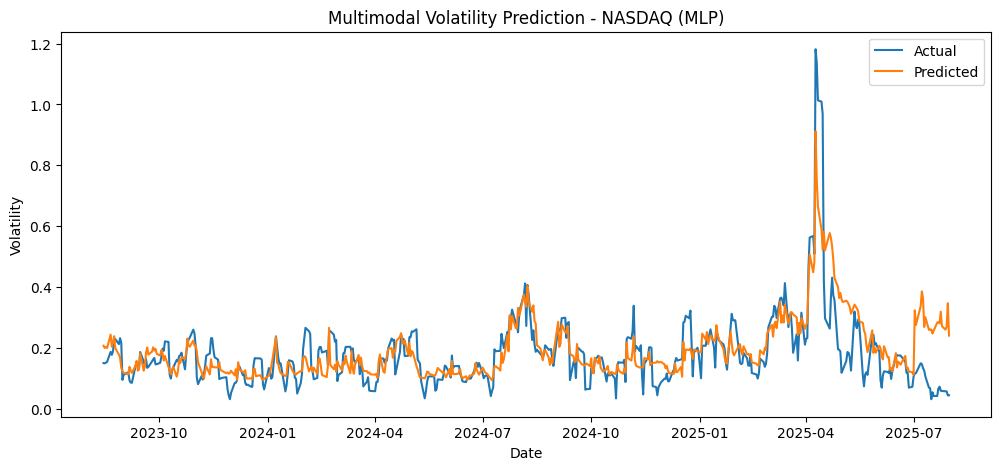

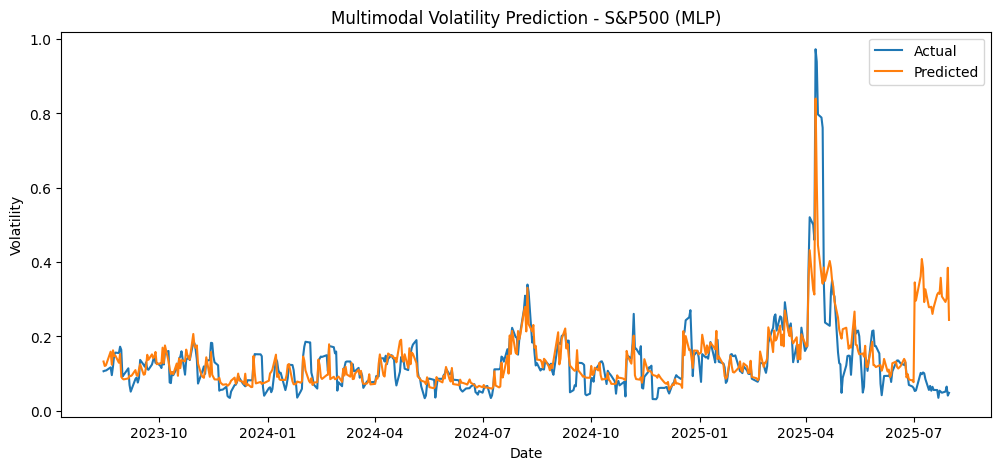

In [12]:
# Visualization
ASSETS = ["AAPL", "IBEX35", "MSFT", "NASDAQ", "S&P500"]

for asset in ASSETS:
    asset_df = pred_df[pred_df["Ticker"] == asset]

    plt.figure(figsize=(12,5))
    plt.plot(asset_df["Date"], asset_df["Actual_Volatility"], label="Actual")
    plt.plot(asset_df["Date"], asset_df["Predicted_Volatility"], label="Predicted")
    plt.title(f"Multimodal Volatility Prediction - {asset} (MLP)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()